<a href="https://colab.research.google.com/github/Ngolobe/Forecasting-The-Stock-Market-with-Machine-Learning/blob/master/deepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow==1.6
# import tensorflow as tf
print(tf.__version__)

1.6.0


In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a f

## Downloading the Data


In [2]:
# Define the instruments to download. We would like to see the S&P500 index.
ticker = '^GSPC'

# We would like all available data from 01/01/1971 until 12/31/2019.
start_date = '1971-01-01'
end_date = '2019-12-31'

# Use pandas_reader.data.DataReader to load the desired data. 
df = data.DataReader('^GSPC', 'yahoo', start_date, end_date)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1971-01-04,92.190002,90.639999,92.150002,91.150002,10010000,91.150002
1971-01-05,92.279999,90.690002,91.150002,91.800003,12600000,91.800003
1971-01-06,93.000000,91.500000,91.800003,92.349998,16960000,92.349998
1971-01-07,93.260002,91.750000,92.349998,92.379997,16460000,92.379997
1971-01-08,93.019997,91.599998,92.379997,92.190002,14100000,92.190002


In [3]:
df = df.reset_index()

In [4]:
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

##Data Exploration and Visualization

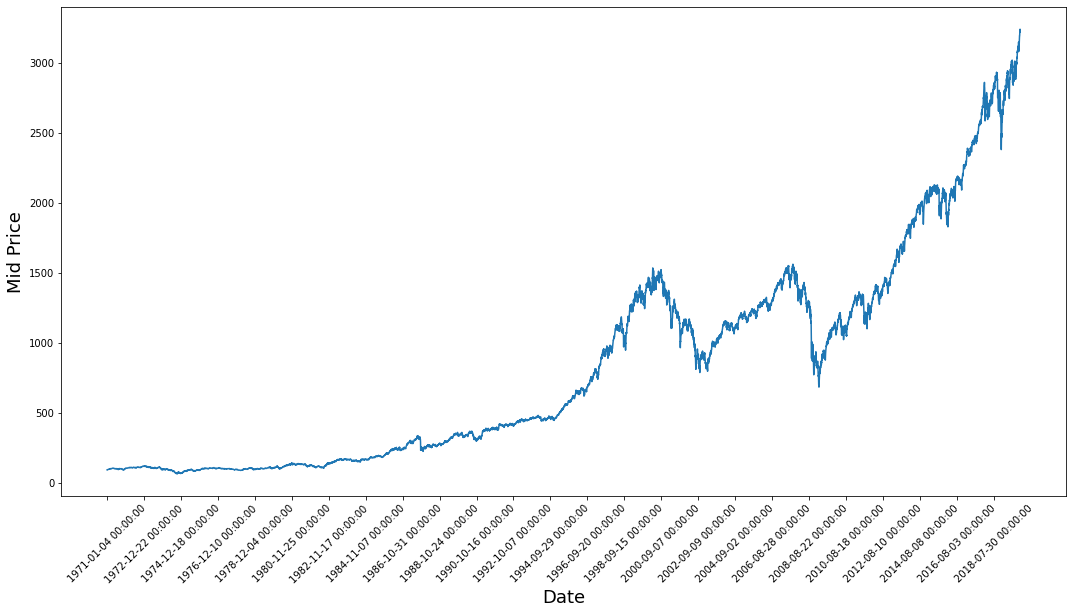

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

##Splitting Data into a Training set and a Test set

In [6]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [7]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

##Normalizing the Data

Now you need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. You can also reshape the training and test data to be in the shape [data_size, num_features].

In [8]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

Due to the observation you made earlier, that is, different time periods of data have different value ranges, you normalize the data by splitting the full series into windows. If you don't do this, the earlier data will be close to 0 and will not add much value to the learning process. Here you choose a window size of 2500.

Tip: when choosing the window size make sure it's not too small, because when you perform windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently.

In this example, 4 data points will be affected by this. But given you have 11,000 data points, 4 points will not cause any issue

In [9]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

Reshape the data back to the shape of [data_size]

In [10]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

You can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

Note that you should only smooth training data.

In [11]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

##One-Step Ahead Prediction via Averaging

Averaging mechanisms allow you to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. You will look at two averaging techniques below; standard averaging and exponential moving average. You will evaluate both qualitatively (visual inspection) and quantitatively (Mean Squared Error) the results produced by the two algorithms.

The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

###Standard Average

You can understand the difficulty of this problem by first trying to model this as an average calculation problem. First you will try to predict the future stock market prices (for example, xt+1 ) as an average of the previously observed stock market prices within a fixed size window (for example, xt-N, ..., xt) (say previous 100 days). Thereafter you will try a bit more fancier "exponential moving average" method and see how well that does. Then you will move on to the "holy-grail" of time-series prediction; Long Short-Term Memory models.

First you will see how normal averaging works. That is you say,
 $$ x_{t+1}=\frac{1}{N}\sum_{i=t-N}^{t} x_{i}$$
In other words, you say the prediction at t+1
is the average value of all the stock prices you observed within a window of t to t−N.

In [12]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00372


Take a look at the averaged results below. It follows the actual behavior of stock quite closely. Next, you will look at a more accurate one-step prediction method.

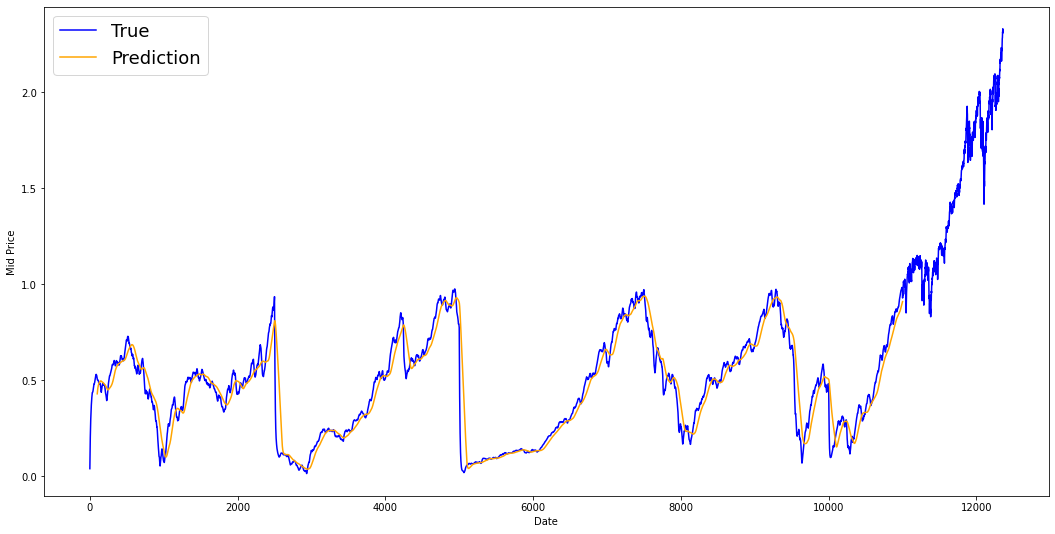

In [13]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

So what do the above graphs (and the MSE) say?

It seems that it is not too bad of a model for very short predictions (one day ahead). Given that stock prices don't change from 0 to 100 overnight, this behavior is sensible. Next, you will look at a fancier averaging technique known as exponential moving average.

###Exponential Moving Average




You might have seen some articles on the internet using very complex models and predicting almost the exact behavior of the stock market. But beware! These are just optical illusions and not due to learning something useful. You will see below how you can replicate that behavior with a simple averaging method.

In the exponential moving average method, you calculate $x_{t+1}$
as,
$$x_{t+1}=EMA_t=\gamma×EMA_{t−1}+(1−\gamma)x_t$$

where $EMA_{0}=0$ and $EMA$ is the exponential moving average value you maintain over time.

The above equation basically calculates the exponential moving average from t+1 time step and uses that as the one step ahead prediction. γ decides what the contribution of the most recent prediction is to the EMA. For example, a γ=0.1 gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average. See how good this looks when used to predict one-step ahead below.

In [14]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00002


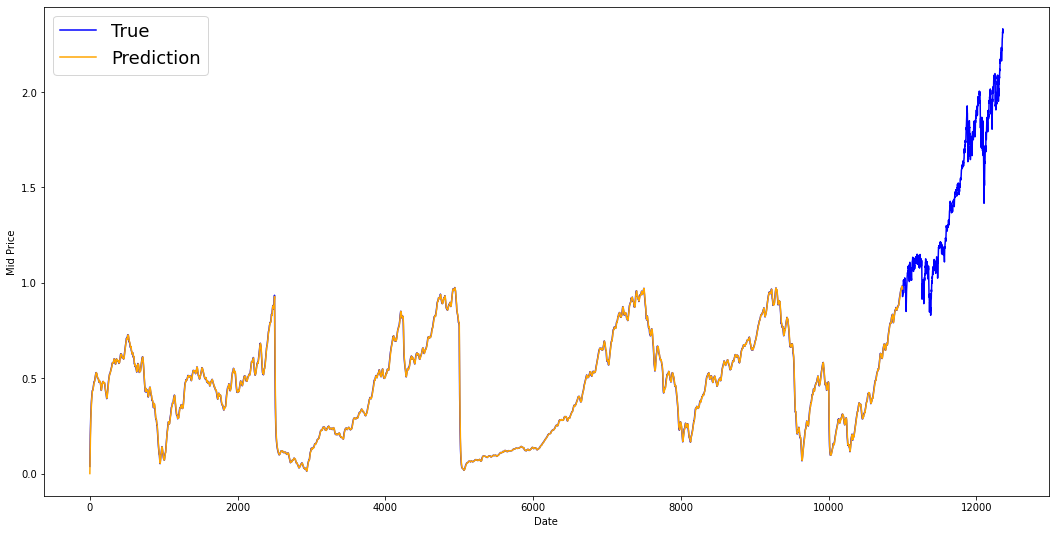

In [15]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

###If Exponential Moving Average is this Good, Why do You Need Better Models?

You see that it fits a perfect line that follows the True distribution (and justified by the very low MSE). Practically speaking, you can't do much with just the stock market value of the next day. Personally what I'd like is not the exact stock market price for the next day, but would the stock market prices go up or down in the next 30 days. Try to do this, and you will expose the incapability of the EMA method.

You will now try to make predictions in windows (say you predict the next 2 days window, instead of just the next day). Then you will realize how wrong EMA can go. Here is an example:

###Predict More Than One Step into the Future

To make things concrete, let's assume values, say $x_t=0.4$, EMA=0.5 and γ=0.5

    Say you get the output with the following equation
        Xt+1 = EMAt = γ × EMAt-1 + (1 - γ)Xt
        So you have xt+1 = 0.5 × 0.5 + (1-0.5) × 0.4 = 0.45
        So Xt+1 = EMAt = 0.45
    So the next prediction Xt+2 becomes,
        Xt+2 = γ × EMAt + (1-γ)Xt+1
        Which is Xt+2 = γ × EMAt + (1-γ) EMAt = EMAt
        Or in this example, Xt+2 = Xt+1 = 0.45

So no matter how many steps you predict in to the future, you'll keep getting the same answer for all the future prediction steps.

One solution you have that will output useful information is to look at momentum-based algorithms. They make predictions based on whether the past recent values were going up or going down (not the exact values). For example, they will say the next day price is likely to be lower, if the prices have been dropping for the past days, which sounds reasonable. However, you will use a more complex model: an LSTM model.

These models have taken the realm of time series prediction by storm, because they are so good at modelling time series data. You will see if there actually are patterns hidden in the data that you can exploit.

#Introduction to LSTMs: Making Stock Movement Predictions Far into the Future

Long Short-Term Memory models are extremely powerful time-series models. They can predict an arbitrary number of steps into the future. An LSTM module (or cell) has 5 essential components which allows it to model both long-term and short-term data.

* Cell state $(c_t)$ - This represents the internal memory of the  which stores both short term memory and long-term memories 
* Hidden state $(h_t)$ - This is output state information calculated w.r.t. current input, previous hidden state and current cell input which you eventually use to predict the future stock market prices. Additionally, the hidden state can decide to only retrive the short or long-term or both types of memory stored in the cell state to make the next prediction.
* Input gate $(i_t)$ - Decides how much information from current input flows to the cell state
*    Forget gate $(f_t)$ - Decides how much information from the current input and the previous cell state flows into the current cell state
*    Output gate $(o_t)$ - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long-term memories

A cell is pictured below.

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1523953369/lstm_xszk4d.png)

And the equations for calculating each of these entities are as follows.

* $i_t = \sigma(W_{ix}X_t + W_{ih}h_{t-1} + b_i)$
* $\tilde{c}_t=\sigma(W_{cx}x_t+W_{ch}h_{t−1}+b_c)$
* $f_t=\sigma(W_{fx}x_t+W_{fh}h_{t−1}+b_f)$
* $c_t=f_tc_{t−1}+i_t\tilde{c}_t$
* $o_t=\sigma(W_{ox}x_t+W_{oh}h_{t−1}+b_o)$
* $h_t=o_ttanh(c_t)$

For a better (more technical) understanding about LSTMs you can refer to this article.

TensorFlow provides a nice sub API (called RNN API) for implementing time series models. You will be using that for your implementations.


In [16]:
#https://www.datacamp.com/community/tutorials/lstm-python-stock-market?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034349&utm_targetid=dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1005582&gclid=EAIaIQobChMIx9_k0Mnt6wIVjNwYCh0HBwpnEAAYASAAEgLox_D_BwE#comments


###Data Generator

You are first going to implement a data generator to train your model. This data generator will have a method called .unroll_batches(...) which will output a set of num_unrollings batches of input data obtained sequentially, where a batch of data is of size [batch_size, 1]. Then each batch of input data will have a corresponding output batch of data.

For example if num_unrollings=3 and batch_size=4 a set of unrolled batches it might look like,

* input data: $[x0,x10,x20,x30],[x1,x11,x21,x31],[x2,x12,x22,x32]$

* output data: $[x1,x11,x21,x31],[x2,x12,x22,x32],[x3,x13,x23,x33]$

###Data Augmentation

Also to make your model robust you will not make the output for $x_t$ always $x_t+1$. Rather you will randomly sample an output from the set $x_{t+1},x_{t+2},…,x_{t+N}$ where $N$ is a small window size.

Here you are making the following assumption:

* $x_{t+1},x_{t+2},…,x_{t+N}$ will not be very far from each other

I personally think this is a reasonable assumption for stock movement predictions.

Below you illustrate how a batch of data is created visually.

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1523953369/batch_pno02e.png)

In [17]:

class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)




Unrolled index 0
	Inputs:  [0.03767911 0.58830804 0.5755851  0.38477522 0.5875039 ]

	Output: [0.13201785 0.5935842  0.58228415 0.38477522 0.59577143]


Unrolled index 1
	Inputs:  [0.07168027 0.5888167  0.57898223 0.3859211  0.5897172 ]

	Output: [0.18009323 0.5968175  0.58228415 0.38664472 0.5977551 ]


Unrolled index 2
	Inputs:  [0.10326442 0.59039253 0.58228415 0.38664472 0.5919654 ]

	Output: [0.15764534 0.5935842  0.59082437 0.39493084 0.5919654 ]


Unrolled index 3
	Inputs:  [0.13201785 0.5935842  0.5853875  0.38817886 0.59384185]

	Output: [0.20109951 0.5990968  0.59082437 0.39711466 0.60334325]


Unrolled index 4
	Inputs:  [0.15764534 0.59582704 0.5882728  0.39050433 0.59577143]

	Output: [0.18009323 0.5968175  0.5981146  0.39493084 0.60553104]


###Defining Hyperparameters

In this section, you'll define several hyperparameters. **D** is the dimensionality of the input. It's straightforward, as you take the previous stock price as the input and predict the next one, which should be **1**.

Then you have **num_unrollings**, this is a hyperparameter related to the backpropagation through time (BPTT) that is used to optimize the LSTM model. This denotes how many continuous time steps you consider for a single optimization step. You can think of this as, instead of optimizing the model by looking at a single time step, you optimize the network by looking at **num_unrollings** time steps. The larger the better.

Then you have the **batch_size**. Batch size is how many data samples you consider in a single time step.

Next you define **num_nodes** which represents the number of hidden neurons in each cell. You can see that there are three layers of LSTMs in this example.

In [18]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.get_default_graph # This is important in case you run this multiple times

<function tensorflow.python.framework.ops.get_default_graph>

###Defining Inputs and Outputs

Next you define placeholders for training inputs and labels. This is very straightforward as you have a list of input placeholders, where each placeholder contains a single batch of data. And the list has **num_unrollings** placeholders, that will be used at once for a single optimization step.

In [19]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

###Defining Parameters of the LSTM and Regression layer

You will have a three layers of LSTMs and a linear regression layer, denoted by **w** and **b**, that takes the output of the last Long Short-Term Memory cell and output the prediction for the next time step. You can use the **MultiRNNCell** in TensorFlow to encapsulate the three **LSTMCell** objects you created. Additionally, you can have the dropout implemented LSTM cells, as they improve performance and reduce overfitting.

In [20]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

###Calculating LSTM output and Feeding it to the regression layer to get final prediction

In this section, you first create TensorFlow variables (**c** and **h**) that will hold the cell state and the hidden state of the Long Short-Term Memory cell. Then you transform the list of **train_inputs** to have a shape of [**num_unrollings, batch_size, D**], this is needed for calculating the outputs with the **tf.nn.dynamic_rnn** function. You then calculate the LSTM outputs with the **tf.nn.dynamic_rnn** function and split the output back to a list of **num_unrolling** tensors. the loss between the predictions and true stock prices.

In [22]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

###Loss Calculation and Optimizer

Now, you'll calculate the loss. However, you should note that there is a unique characteristic when calculating the loss. For each batch of predictions and true outputs, you calculate the Mean Squared Error. And you sum (not average) all these mean squared losses together. Finally, you define the optimizer you're going to use to optimize the neural network. In this case, you can use Adam, which is a very recent and well-performing optimizer.

In [23]:
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


###Prediction Related Calculations

Here you define the prediction related TensorFlow operations. First, define a placeholder for feeding in the input (**sample_inputs**), then similar to the training stage, you define state variables for prediction (**sample_c** and **sample_h**). Finally you calculate the prediction with the **tf.nn.dynamic_rnn** function and then sending the output through the regression layer (**w** and **b**). You also should define the **reset_sample_state** operation, which resets the cell state and the hidden state. You should execute this operation at the start, every time you make a sequence of predictions.

In [24]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')



Defining prediction related TF functions
	All done


###Running the LSTM